# Community Detection Algorithms

We apply three distinct algorithms to detect community structures within the network. These methods rely on different mathematical definitions of what constitutes a "community".

### Louvain Algorithm: 
The Louvain method is a heuristic algorithm based on Modularity Optimization. It is a greedy, iterative method that works in two phases:
1. Local Moving: Nodes are moved to neighbor communities if the move increases the graph's modularity ($Q$)
2. Aggregation: The graph is rebuilt where communities become single "super-nodes," and edge weights are summed. This process repeats until modularity no longer increases.

<cite>
Blondel, V. D., Guillaume, J. L., Lambiotte, R., & Lefebvre, E. (2008). Fast unfolding of communities in large networks. Journal of statistical mechanics: theory and experiment, 2008(10), P10008.
</cite>

Documentation for the implementations used in this notebook: [NetworkX Louvain](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html)

### Leiden Algorithm
The Leiden algorithm is an improvement upon Louvain. It addresses the issue of disconnected communities and generally yields partitions with higher quality. It introduces a refinement phase between the moving and aggregation steps:
1. Local Moving: Similar to Louvain (fast modularity optimization).
2. Refinement: Communities are locally split to ensure they are well-connected.
3. Aggregation: The network is aggregated based on the refined partition.

<cite>
Traag, V. A., Waltman, L., & Van Eck, N. J. (2019). From Louvain to Leiden: guaranteeing well-connected communities. Scientific reports, 9(1), 1-12.
</cite>

### Spectral Clustering
Spectral Clustering uses the eigenvalues (spectrum) of the graph's Laplacian matrix to perform dimensionality reduction before clustering.
1. Construct the Laplacian matrix from the graph's adjacency matrix.
2. Compute the first $k$ eigenvectors to embed the nodes into a lower-dimensional space.
3. Apply a standard clustering algorithm (like K-Means) on these vectors to separate the nodes. Unlike Louvain/Leiden which optimize density, Spectral Clustering approximates the Min-Cut problem (minimizing the number of edges cut to separate the graph).

<cite>
Ng, A., Jordan, M., & Weiss, Y. (2001). On spectral clustering: Analysis and an algorithm. Advances in neural information processing systems, 14.
</cite>

In [59]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import SpectralClustering
from collections import defaultdict
import time

from utils import (
    load_email, run_leiden,
    metric_avg_conductance, metric_internal_density, metric_coverage, metric_ari
)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
G = load_email(directed=False)
gt = nx.get_node_attributes(G, 'ground_truth')

print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Is Directed: {G.is_directed()}")

Nodes: 986
Edges: 16064
Is Directed: False


In [61]:
def optimize_community_detection(G, algorithm_name, param_range, ground_truth=None):
    results = []
    print(f"--- Optimizing {algorithm_name} ---")
    
    start_time = time.time()
    
    for param in param_range:
        try:
            # run algorithm
            if algorithm_name == "louvain":
                comms = nx.community.louvain_communities(G, resolution=param, seed=42)
            elif algorithm_name == "leiden":
                comms = run_leiden(G, resolution=param)
            elif algorithm_name == "spectral":
                # spectral uses k (int)
                k = int(param)
                adj = nx.to_scipy_sparse_array(G, format='csr')
                adj.indices = adj.indices.astype(np.int32)
                adj.indptr = adj.indptr.astype(np.int32)
                sc = SpectralClustering(n_clusters=k, affinity='precomputed', 
                                      assign_labels='discretize', random_state=42, n_init=10)
                labels = sc.fit_predict(adj)
                
                d = defaultdict(set)
                for node, label in zip(G.nodes(), labels): d[label].add(node)
                comms = list(d.values())
        except Exception as e:
            continue

        # metrics
        cond = metric_avg_conductance(G, comms)
        dens = metric_internal_density(G, comms)
        cov = metric_coverage(G, comms)
        
        # composite Score: 40% (1-Conductance) + 30% Density + 30% Coverage
        composite_score = (0.4 * (1 - cond)) + (0.3 * dens) + (0.3 * cov)
        
        # Check ARI (Reference only)
        ari = metric_ari(G, comms, ground_truth) if ground_truth else None
        
        results.append({
            "Algorithm": algorithm_name.capitalize(),
            "Param": param,
            "Communities": len(comms),
            "Composite_Score": composite_score,
            "Conductance": cond, # Lower is better
            "Density": dens,     # Higher is better
            "Coverage": cov,     # Higher is better
            "ARI": ari           # Higher is better
        })

    end_time = time.time()
    duration = end_time - start_time
    print(f"{algorithm_name} finished in {duration:.2f} seconds.")

    return pd.DataFrame(results)

In [62]:
# A. Resolution-based Algorithms (Louvain / Leiden)
resolutions = np.linspace(0.2, 5.0, 20)
df_leiden = optimize_community_detection(G, "leiden", resolutions, gt)
df_louvain = optimize_community_detection(G, "louvain", resolutions, gt)

# B. Count-based Algorithms (Spectral)
k_values = range(5, 65, 5) 
df_spectral = optimize_community_detection(G, "spectral", k_values, gt)

--- Optimizing leiden ---
leiden finished in 2.04 seconds.
--- Optimizing louvain ---
louvain finished in 5.96 seconds.
--- Optimizing spectral ---
spectral finished in 2.99 seconds.


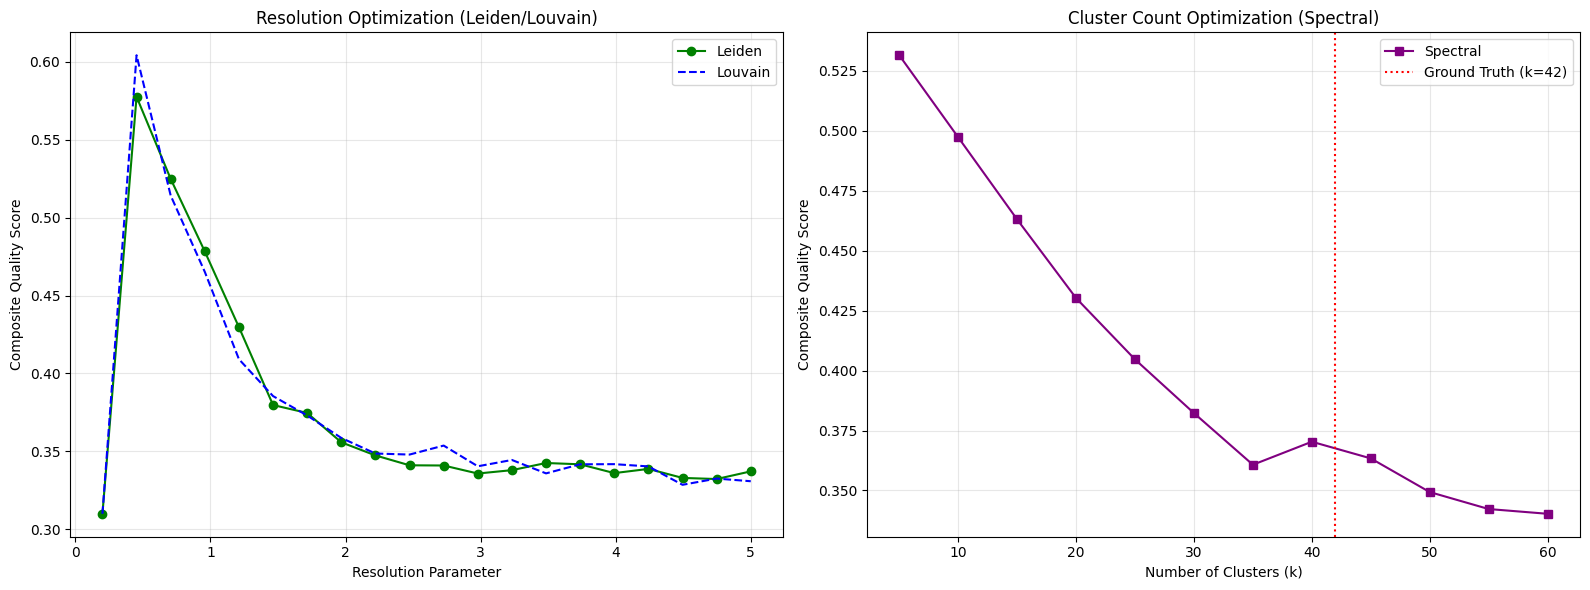

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Resolution Optimization
ax1.plot(df_leiden['Param'], df_leiden['Composite_Score'], label='Leiden', color='green', marker='o')
ax1.plot(df_louvain['Param'], df_louvain['Composite_Score'], label='Louvain', color='blue', linestyle='--')
ax1.set_title("Resolution Optimization (Leiden/Louvain)")
ax1.set_xlabel("Resolution Parameter")
ax1.set_ylabel("Composite Quality Score")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: K Optimization
ax2.plot(df_spectral['Param'], df_spectral['Composite_Score'], label='Spectral', color='purple', marker='s')
ax2.axvline(x=42, color='red', linestyle=':', label='Ground Truth (k=42)')
ax2.set_title("Cluster Count Optimization (Spectral)")
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Composite Quality Score")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [64]:
def get_best_granular_model(df, min_communities=5):
    """Selects the best score provided the partition isn't trivial (too few groups)"""
    # Filter for reasonable number of communities (avoiding the '2 blobs' result)
    granular_df = df[df['Communities'] >= min_communities].copy()
    if granular_df.empty: return df.loc[df['Composite_Score'].idxmax()] # Fallback
    return granular_df.loc[granular_df['Composite_Score'].idxmax()]

# Select best GRANULAR models (min 10 communities)
best_leiden = get_best_granular_model(df_leiden)
best_louvain = get_best_granular_model(df_louvain)
best_spectral = get_best_granular_model(df_spectral)

# Combine
summary_df = pd.DataFrame([best_leiden, best_louvain, best_spectral])
summary_df.set_index("Algorithm", inplace=True)

# Display columns
display_cols = ["Param", "Communities", "Composite_Score", "ARI", "Conductance", "Density", "Coverage"]
final_view = summary_df[display_cols]

# Apply Gradient Styling
styled_table = final_view.style.background_gradient(
    cmap='Greens', subset=["Composite_Score", "ARI", "Density", "Coverage"]
).background_gradient(
    cmap='Greens_r', subset=["Conductance"] # Low is good
).format("{:.4f}")

print("\n--- FINAL ALGORITHM SHOWDOWN (Best Granular Configurations) ---")
display(styled_table)


--- FINAL ALGORITHM SHOWDOWN (Best Granular Configurations) ---


,Param,Communities,Composite_Score,ARI,Conductance,Density,Coverage
Algorithm,,,,,,,
Leiden,0.7053,6.0000,0.5249,0.2068,0.3426,0.2057,0.6673
Louvain,0.7053,6.0000,0.5142,0.2004,0.3456,0.1738,0.6675
Spectral,5.0000,5.0000,0.5315,0.0990,0.3533,0.1394,0.7700
